 # Cluster analysis of the top 100 valuable FIFA 2020 players
 
In this exercise soccer players skills will be used to determine their positions by using a machine learning technique called K-means clustering which is an unsupervised machine learning algorithm. The algorithm tries to find relationships between the observations which have similair pattern and try to cluster them together. The provided data set do have player's positions but will not include them during clustering, otherwise this exercise is meaningless.
The player's position data will be compared later after the cluster analysis to se how the analysis performed.


### Table of contents:
*   Data cleaning
*   Exploratory data analysis (EDA)
*   Cluster analysis 
*   Conclusion



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

df = pd.read_csv('players_20.csv')

## Data cleaning and Exploratory data analysis (EDA)

In [2]:
#Check the shape of the data frame
df.shape


(18278, 104)

There are 18278 players and 104 features in the data set. We will just focus on the top 100 players in this exercise.

In [3]:
# Extract the top100 players based on their market value
df_top100 = df.sort_values('value_eur',ascending=False)[:100]
df_top100.head()            

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
10,231747,https://sofifa.com/player/231747/kylian-mbappe...,K. Mbappé,Kylian Mbappé,20,1998-12-20,178,73,France,Paris Saint-Germain,...,66+3,62+3,62+3,62+3,66+3,63+3,54+3,54+3,54+3,63+3
5,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,28,1991-06-28,181,70,Belgium,Manchester City,...,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [4]:
# Make a new df with the numerical which consist players personal data and skill rating. Remove the sofifa_id column
df_top100_new = df_top100[df_top100.describe().columns].copy()
df_top100_new.drop(columns=['sofifa_id'],inplace=True)
df_top100_new.head()

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
2,27,175,68,92,92,105500000,290000,5,5,5,...,90,94,27,26,29,9,9,15,15,11
0,32,170,72,94,94,95500000,565000,5,4,4,...,75,96,33,37,26,6,11,15,14,8
10,20,178,73,89,95,93500000,155000,3,4,5,...,70,84,34,34,32,13,5,7,11,6
5,28,181,70,91,91,90000000,370000,4,5,4,...,79,91,68,58,51,15,13,5,10,13
4,28,175,74,91,91,90000000,470000,4,4,4,...,88,91,34,27,22,11,12,6,8,8


In [5]:
# Check for null values
df_top100_new.isnull().any()

age                           False
height_cm                     False
weight_kg                     False
overall                       False
potential                     False
value_eur                     False
wage_eur                      False
international_reputation      False
weak_foot                     False
skill_moves                   False
release_clause_eur             True
team_jersey_number            False
contract_valid_until          False
nation_jersey_number           True
pace                           True
shooting                       True
passing                        True
dribbling                      True
defending                      True
physic                         True
gk_diving                      True
gk_handling                    True
gk_kicking                     True
gk_reflexes                    True
gk_speed                       True
gk_positioning                 True
attacking_crossing            False
attacking_finishing         

It appears that some skillset have null values. It is probably due to goalkeeper don't have a certain skillset that other players have and vice versa. We will replace the nulls with 0.

In [6]:
df_top100_new=df_top100_new.fillna(0)
df_top100_new.isnull().any()

age                           False
height_cm                     False
weight_kg                     False
overall                       False
potential                     False
value_eur                     False
wage_eur                      False
international_reputation      False
weak_foot                     False
skill_moves                   False
release_clause_eur            False
team_jersey_number            False
contract_valid_until          False
nation_jersey_number          False
pace                          False
shooting                      False
passing                       False
dribbling                     False
defending                     False
physic                        False
gk_diving                     False
gk_handling                   False
gk_kicking                    False
gk_reflexes                   False
gk_speed                      False
gk_positioning                False
attacking_crossing            False
attacking_finishing         

All null values are now replaced. Let's explore the data set before cluster analysis.


## Exploratory data analysis (EDA)

Time to do some EDA to get a better picture of our data set.

Let's plot how the age distribution is among the top 100 valuable players

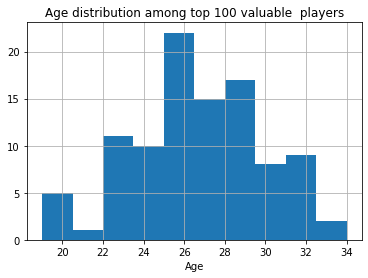

In [7]:
df_top100['age'].hist()
plt.xlabel('Age')
plt.title('Age distribution among top 100 valuable  players')
plt.show()

From the histogram one can see that the average age is around 26 year and that the age distribution is normal distributed.


As mentioned earlier, player's positions will not be included in the clustering. But for the EDA, the positions can be intereting to explore. Let's see how the positions are denoted for some of the players first


In [8]:
df_top100[['short_name','player_positions']].head()

,short_name,player_positions
2,Neymar Jr,"LW, CAM"
0,L. Messi,"RW, CF, ST"
10,K. Mbappé,"ST, RW"
5,K. De Bruyne,"CAM, CM"
4,E. Hazard,"LW, CF"


For convenience, the positions from the data set need to be translated into the four positions: <i>Goalkeeper</i>, <i>Defender</i>, <i>Midfielder</i> and <i>Striker</i>.

At the moment the positions are divided into sub-groups. For instance, Messi can have either following positions: <i>RW</i>, <i>CF</i> and <i>ST</i> which are different positions for a striker. 
The sub-positions will be replaced with one of the main positions.

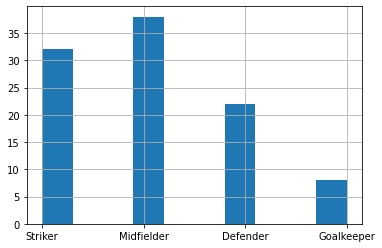

In [9]:
# Plot number of players for each positions

def change_pos_name(row):
    """
    INPUT: Players postions, the sub-group
    OUTPUT: One of the main four positions
    
    The function replaces the sub-group positions and 
    return one of the main four position to respectively player
    
    """
    if row.replace(",",'').split()[0] in ("RB" , "CB" , "LB" , "RCB" , "RWB" , "LCB"):
         return 'Defender'
    if row.replace(",",'').split()[0] in ("RW" , "CF" , "LW" , "ST" , "RS" , "LS" , "LF" , "RF" ):
        return 'Striker'
    if row.replace(",",'').split()[0] in ("RM" , "CM" , "LM" , "CAM" , "LDM" , "RDM" , "LAM" , "RAM" , "CDM", "RCM", "LCM"):
        return 'Midfielder'
    else:
        return 'Goalkeeper'


df_top100['player_positions_update']=df_top100['player_positions'].apply(lambda row:change_pos_name(row))
df_top100['player_positions_update'].hist()
plt.show()

Midfielder is the dominating position and goalkeeper is the least dominating position.

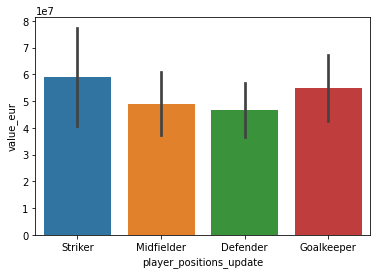

In [10]:
# Plot the average salary for each positions
sns.barplot(x='player_positions_update', y='value_eur',data=df_top100,ci="sd")
plt.show()

Despite goalkeeper is the least dominating positions among 100 most valuable players, it has the second largest average salary. Highest salary does striker has and it is also the position with the highest variance among all positions. Defender has the least variance.
Let's plot the relation between Wage vs Value for each position

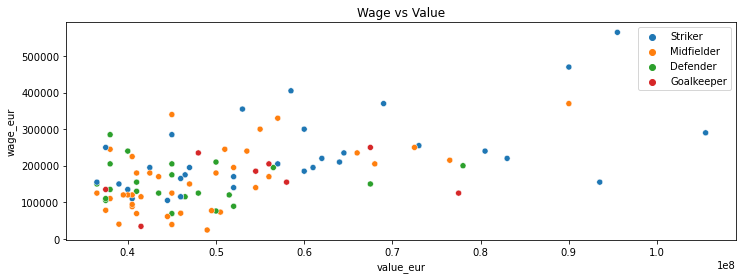

In [11]:
# Plot Wage vs Value for the positions

plt.figure(figsize=(12,4))
sns.scatterplot(data=df_top100, x="value_eur", y="wage_eur", hue='player_positions_update')
plt.title('Wage vs Value')
plt.legend()
plt.show()

When it comes to value, the scatterplot complies with the previous barplot. There is one midfielder that stands out when it comes to value. However, majority of the midfielder only has 50% of that value which also lower the average salary as can be seen in the barplot. The trend for each position is the same, that is, a higher value gives a higher wage. However, the trend is different, striker has the strongest trend and goalkeeper seems to have an almost horizontal trend.

Let's also see if age matters and plot the top 10 players with highest value. The age will be divided into three categories <i>Low age</i>, <i>Mid age</i> and <i>High age</i>.

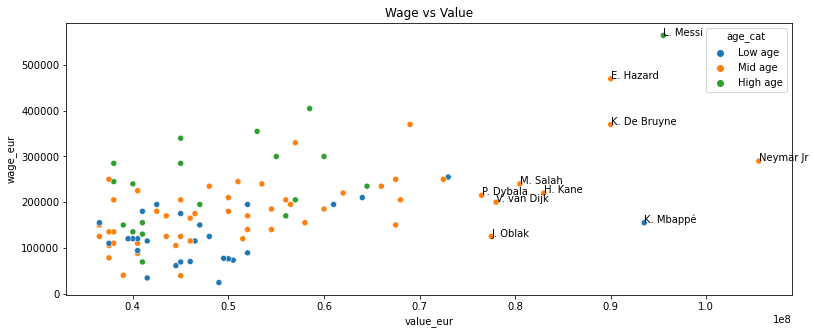

In [12]:
df_top100_new['age_cat']=pd.cut(df_top100['age'],bins=[19,24,29,34],include_lowest=True,labels=['Low age', 'Mid age', 'High age'] )

fig, ax = plt.subplots(figsize=(13,5))

sns.scatterplot(data=df_top100_new, x="value_eur", y="wage_eur", hue='age_cat')

# top valueable players name
top10_name = df_top100.sort_values(ascending=False, by='value_eur')[:10]['short_name']
top10 =  df_top100.sort_values(ascending=False, by='value_eur')[:10]

# Annotate the top valueable players name
for i, txt in enumerate(top10_name):
    ax.annotate(txt, (top10['value_eur'].iloc[i], top10['wage_eur'].iloc[i]))
plt.title('Wage vs Value')
plt.show()

From the plot we can see a trend that higher value yield a higher wage. 
Player with a higher age tends to have a higher salary comapred to the younger players with similair value. Most of the younger players have also a lower value.

Now let's see which are the top 10 countries among the top 100 valuable players

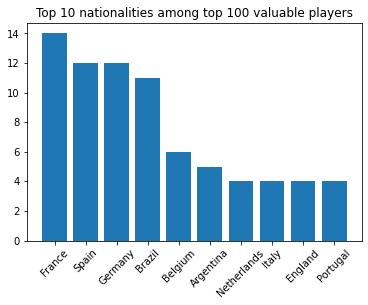

In [13]:
nationality_count = df_top100.groupby('nationality')['sofifa_id'].count().sort_values(ascending=False)
plt.bar(nationality_count.index[:10],nationality_count[:10])
plt.xticks(rotation=45 )
plt.title('Top 10 nationalities among top 100 valuable players')
plt.show()


The European countries are dominating. Only Brazil and Argentina are from outside Europe.

# Cluster analysis with K-means clustering

Before I do the clustering I need to choose some features that I need. There are 104 features in total in the data set but I will just choose a few of them that I think are relevant. The values will be standardized so we are normal distributed. We will then determine the number of clusters we will use with <i>Elbow method</i>. Lastly we will try to identify which positions each cluster is represented.

In [14]:
# Choose the features we will use
col = ['weak_foot', 'skill_moves',
       'shooting','passing', 'dribbling', 'defending',  
       'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes',
      
      'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys']

df_top100_update = df_top100_new[col]


In [15]:
# Standardise the valaues
standard = StandardScaler()
df_standard = standard.fit_transform(df_top100_update)
df_standard

array([[ 2.03370393,  1.5571859 ,  0.72609004, ..., -0.1352625 ,
         0.59977122,  0.96577751],
       [ 0.65957965,  0.64655087,  1.01504003, ...,  0.2640364 ,
         1.01512525,  1.00896971],
       [ 0.65957965,  1.5571859 ,  0.68481147, ...,  0.61342293,
         0.18441719,  0.62023994],
       ...,
       [-0.71454462,  0.64655087, -0.09948135, ...,  0.16421167,
         0.10134638, -0.1140274 ],
       [ 0.65957965,  0.64655087,  0.39586148, ..., -1.03368502,
         0.10134638,  0.36108676],
       [ 2.03370393, -0.26408416,  0.60225433, ...,  0.71324766,
        -0.48014926,  0.83620092]])

In [16]:
# Perform K-means clustering. Assuming 1 to 10 clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, 
                    init = 'k-means++', 
                    random_state = 7)
    kmeans.fit(df_standard)
    wcss.append(kmeans.inertia_)

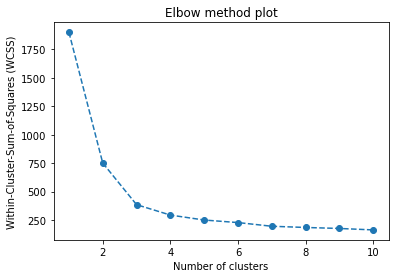

In [17]:
# Plot sum of squared distances of samples to their closest cluster center vs number of clusters
plt.plot(range(1,11),wcss,'o--')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
plt.title('Elbow method plot')
plt.show()

From the elbow method plot we can see that the elbow start at 3 clusters. 
However we now that there are 4 distinct positions in football (goalkeeper, defender, midfielder, striker). So we will choose 4 clusters for our case. Elbow method is just an indicator and sometimes it can be also be hard to find the elbow if the sum of squared distances does not drop sharply.

We will use 4 clusters for our cluster analysis

In [18]:
# K-means with 4 clusters

kmeans =KMeans(n_clusters = 4,
               init = 'k-means++',
               random_state = 7)
kmeans.fit(df_standard)

KMeans(n_clusters=4, random_state=7)

In [19]:
# print the cluster for each 100 players

kmeans.labels_

array([3, 3, 3, 0, 3, 3, 3, 1, 2, 3, 3, 0, 3, 3, 2, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 0, 1, 2, 3, 1, 0, 2, 1, 3, 1, 3, 0, 3, 1, 0, 0, 0, 1,
       1, 0, 0, 2, 0, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3,
       1, 3, 3, 0, 0, 2, 1, 0, 1, 0, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0,
       0, 1, 0, 1, 1, 2, 3, 3, 1, 0, 3, 3])

In [20]:
df_kmeans = df_top100_update.copy()
df_kmeans['cluster'] = kmeans.labels_
df_kmeans_analysis = df_kmeans.groupby('cluster').mean() 
df_kmeans_analysis

,weak_foot,skill_moves,shooting,passing,dribbling,defending,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys
cluster,,,,,,,,,,,,,,,,,,,
0,3.75000,3.625000,74.416667,83.708333,84.000000,73.625000,73.458333,74.500000,70.875000,9.375000,10.625000,10.208333,10.666667,9.875000,79.083333,71.750000,65.916667,87.041667,71.333333
1,3.00000,2.272727,52.181818,68.000000,69.000000,85.909091,87.272727,86.954545,84.954545,11.227273,9.727273,10.772727,10.500000,11.090909,57.272727,47.090909,79.045455,78.590909,41.272727
2,3.00000,1.000000,0.000000,0.000000,0.000000,0.000000,22.625000,15.625000,13.625000,87.000000,84.750000,80.500000,86.250000,89.125000,15.375000,12.875000,15.125000,44.250000,14.000000
3,3.73913,4.000000,82.760870,79.630435,86.217391,42.739130,41.108696,40.869565,34.347826,10.326087,10.021739,10.978261,10.217391,10.565217,77.804348,83.913043,65.847826,82.739130,81.130435


We grouped each cluster and averaged all the values. From the table we can already see some interesting patterns:

*    Cluster 1 has very high value when it comes to defending
*    Cluster 2 has value zero for skills like shooting, passin, dribbling and defending. But very high value for goalkeeping skills


We can almost conclude that Cluster 1 is defender and Cluster 2 is goalkeeper. Let's look how each cluster are distributed for each skill

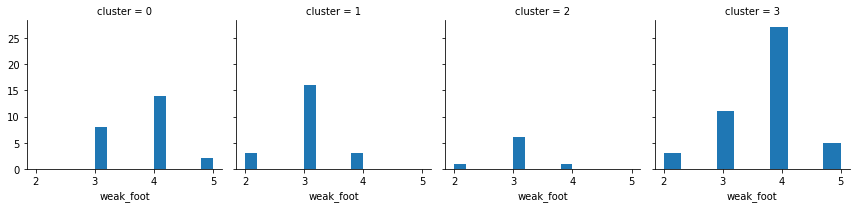

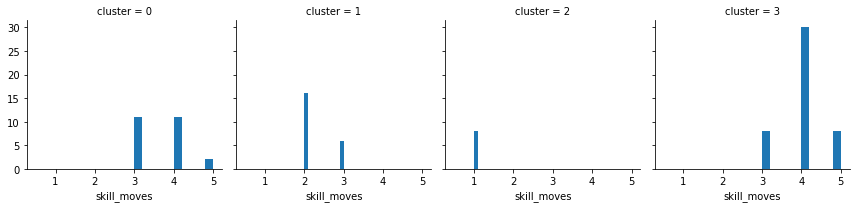

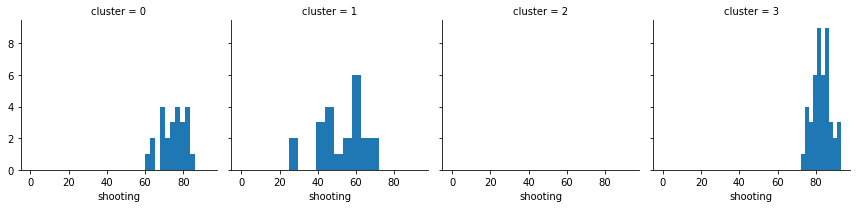

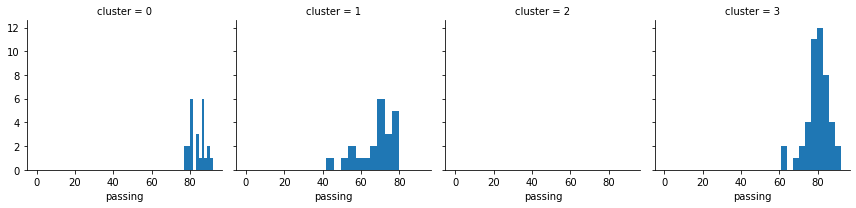

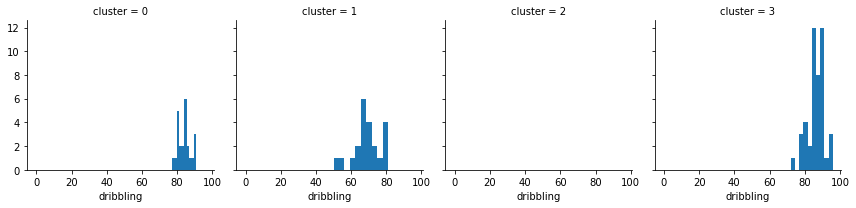

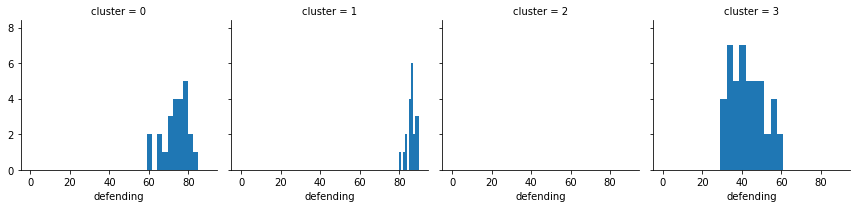

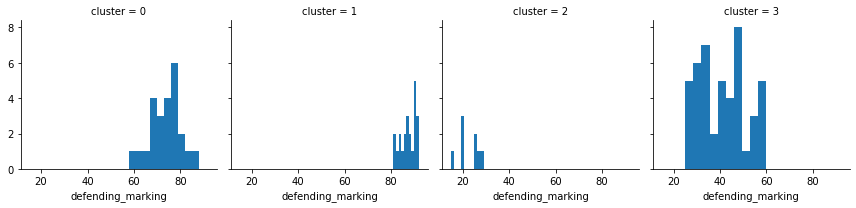

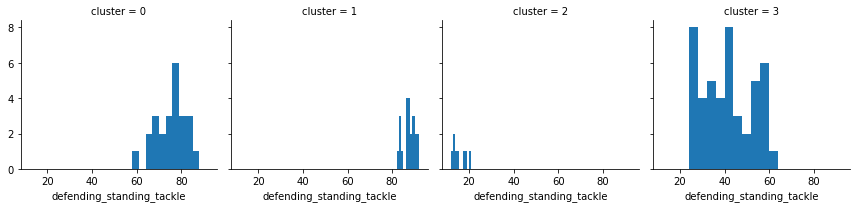

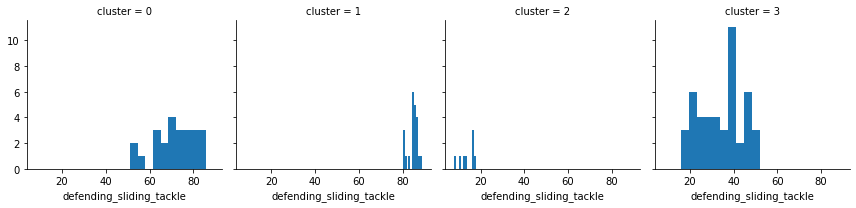

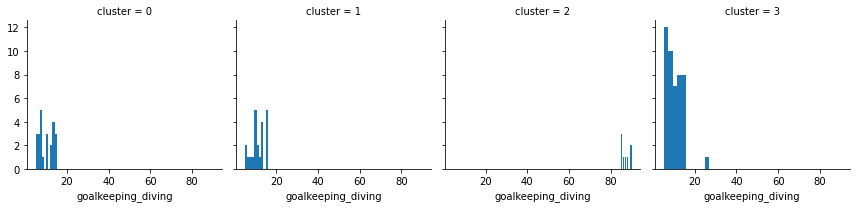

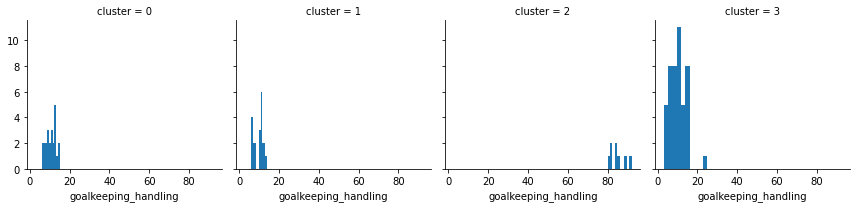

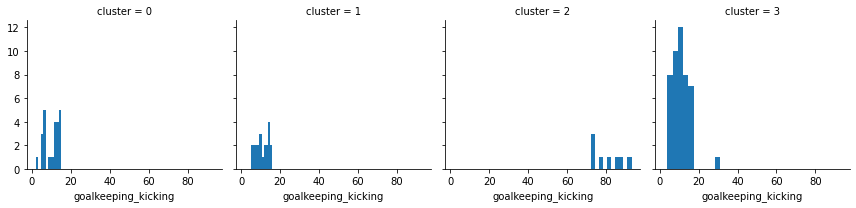

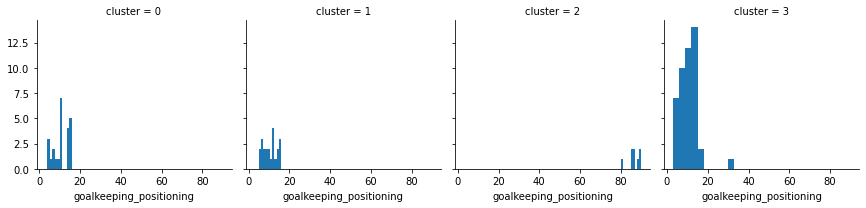

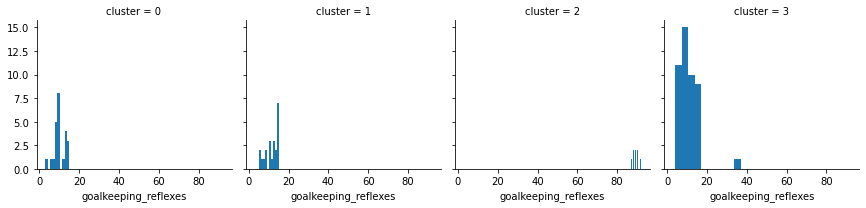

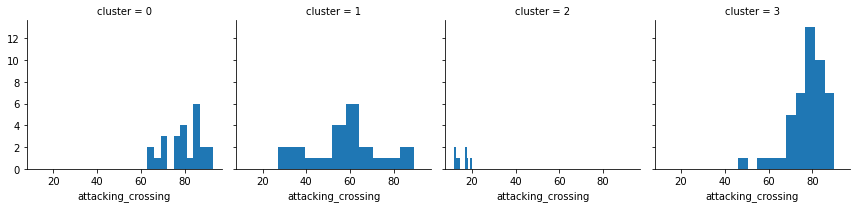

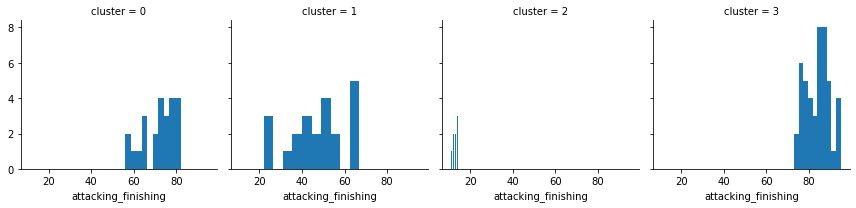

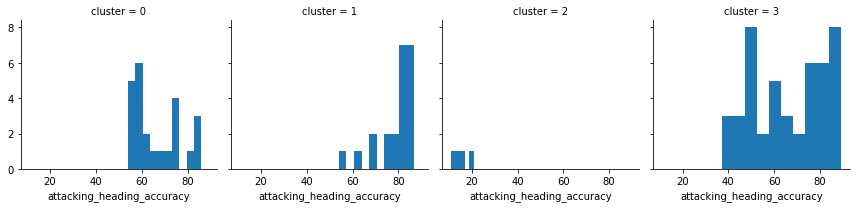

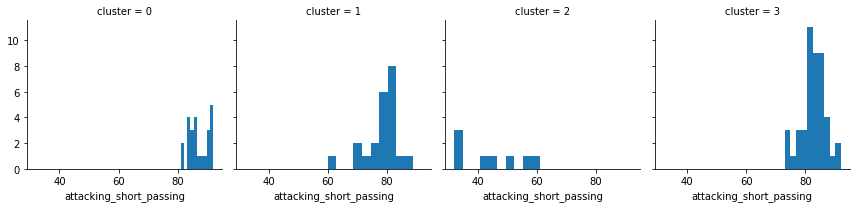

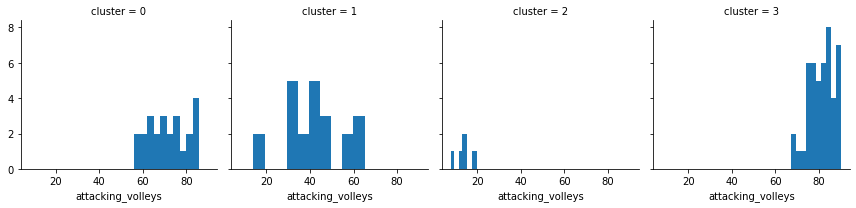

In [21]:
#Visualise each skill for each cluster in a histogram 
pd.options.display.max_rows = 10500
df_kmeans_i = df_kmeans.reset_index()
for i in df_kmeans_i.iloc[:,1:20]:
    grid= sns.FacetGrid(df_kmeans_i, col='cluster')
    grid.map(plt.hist, i)
    plt.show()

From the histograms one can see that there are some skills that cluster 1 and cluster 2 respectively have that are more dominating compare to the other clusters. This complies with the table above.

Let's see how the clusters are related to each other and between the skills

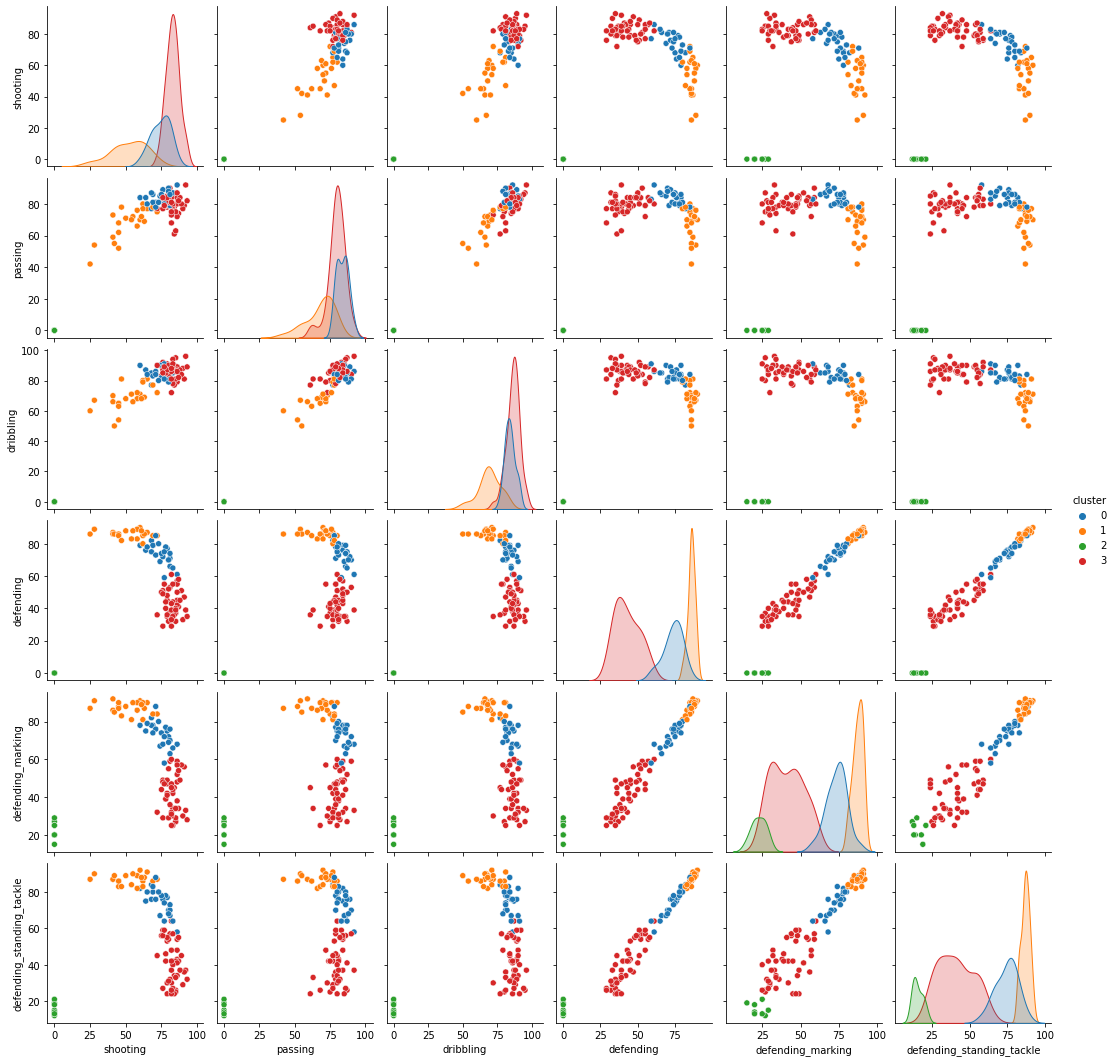

In [22]:
import warnings
warnings.filterwarnings("ignore")
sns.pairplot(df_kmeans,vars=['shooting','passing', 'dribbling', 'defending',  
                            'defending_marking', 'defending_standing_tackle'],                           
                             hue='cluster',palette="tab10")


plt.show()

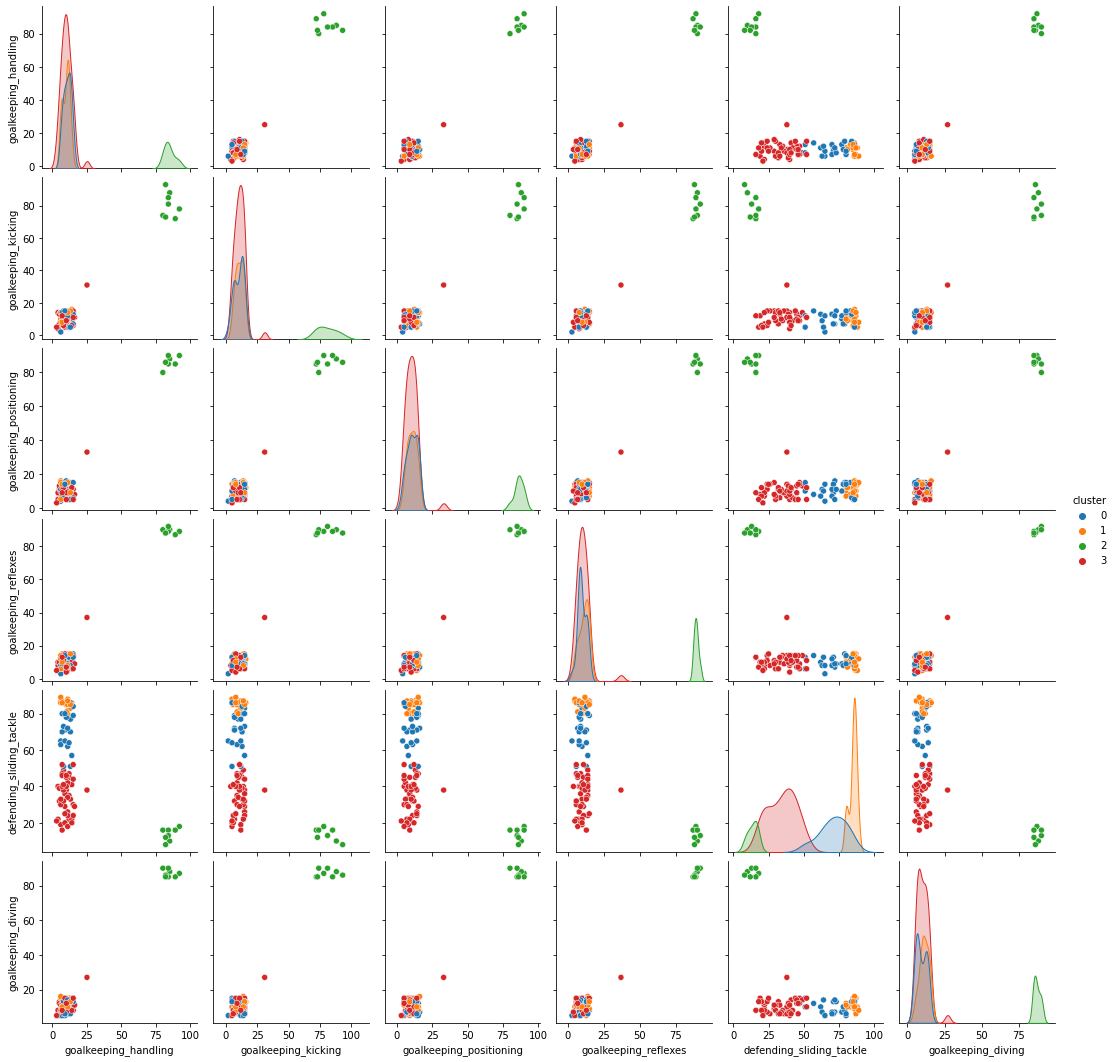

In [23]:
sns.pairplot(df_kmeans,vars=[  'goalkeeping_handling', 'goalkeeping_kicking',
                           'goalkeeping_positioning', 'goalkeeping_reflexes',
                            'defending_sliding_tackle', 'goalkeeping_diving'],
                             hue='cluster',palette="tab10")
plt.show()

Again, from the pairplots we can distinguish the cluster 1 and cluster 2 easier compared to the other two clusters. For cluster 0 and cluster 3 the observations are more clustered together for certain skills which implies that some players have a midfielder and a striker role. This also applies for some midfielders and defenders but it is not as common according to the plots. From the histogram the values for cluster 3 were higher in terms of the skills <i>shooting</i> and <i>attacking_finishing</i> which implies that cluster 3 is striker and cluster 0 is midfielder. 

In [24]:
# Change cluster number to position name
df_kmeans['cluster']=df_kmeans['cluster'].map({0:"Midfielder",
                                               1:"Defender",
                                               2:"Goalkeeper",
                                               3:"Striker"})


We will compare the cluster results with the player position that was provided from the data set.

In [25]:

                                                
    
# Take only the top 100 valuable players from the ordignial data set
player_name = df.loc[df_kmeans.index][['short_name','player_positions']]

# Update players positions with the new position name
player_name['player_positions']=player_name['player_positions'].apply(lambda row:change_pos_name(row))

player_cluster = pd.concat([player_name,df_kmeans],axis=1)[['short_name','player_positions','cluster']]
player_cluster

,short_name,player_positions,cluster
2,Neymar Jr,Striker,Striker
0,L. Messi,Striker,Striker
10,K. Mbappé,Striker,Striker
5,K. De Bruyne,Midfielder,Midfielder
4,E. Hazard,Striker,Striker
12,H. Kane,Striker,Striker
9,M. Salah,Striker,Striker
7,V. van Dijk,Defender,Defender
3,J. Oblak,Goalkeeper,Goalkeeper
23,P. Dybala,Midfielder,Striker


We can see that there are some differences, it is mostly the midfielder positions that appears to be harder to cluster. We can calculate and see how many mismatches there are among the 100 players.

In [26]:
def compare(row):
    """
    INPUT: Each players positions from the data set and from the cluster
    OUTPUT: 1 or 0 depending if it is equal or not
    
    The function compare the positions from the data set with the cluster analysis.
    If the positions are equal the funcion return 0, otherwise it return 1.
    """
    
    if row[1] != row[2]:
        
        return 1
    else:
        return 0

not_equal = []
not_equal.append(player_cluster.apply(lambda row: compare(row),axis=1))

np.array(not_equal).sum()


22

# Conclusion

From the data set I took the most valuable 100 players.
EDA showed:
*    Midfielder are the dominating position and goalkeeper is least dominating position
*    Striker has highest average salary and goalkeeper has the second highest. Defender has the lowest average salary.
*    The average age among the players are around 26 years
*    Younger players value more skewed to lower range compared to the other age group
*    Top 10 countries are dominated by European countries with France, Spain and Germany as top 3. Brazil and Argentina are the only countries that are not from Europe.

Different method were performed to see patterns among the clusters during the cluster analysis. Two distinct clusters could be distinguished from the cluster analysis which belonged to defender and goalkeeper. Striker and midfielder positions were harder due to some players maybe switching between positions striker and midfielder or a midfielder maybe play a more offensive role or vice versa.
Lastly, the positions that were determined by the cluster analysis were compared with the positions provided from the data set. 22 of 100 positions of did not match with the provided data. Considering that some players can have both defensive/offensive positions which makes it harder for the cluster to distinguish some players positions. This is considering fairly good clustering without tweaking the parameter. Some further works can be done in the future to make the results better.
